In [60]:
# import the usual
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR, NuSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from matplotlib.ticker import MaxNLocator

Here, we put the csv files into dataframe and we try to fit them into X and Y

In [61]:
# put the two csv files into two distinct dataframes
df_attendance = pd.read_csv('attendance.csv')
df_games = pd.read_csv('games.csv')

# excluding the years that the league had less than 32 teams
excludeYears = [2000, 2001]

# Removes any rows containing a null value from the datasets
df_attendance = df_attendance[~df_attendance['year'].isin(excludeYears)]
df_attendance = df_attendance.dropna()
# dropping redundant values that could influence our results 
droppit = ['team', 'total', 'home', 'away']
df_attendance = df_attendance.drop(droppit, axis=1)
df_attendance.rename(columns={'team_name': 'home_team_name'}, inplace=True)
df_attendance['week'] = df_attendance['week'].astype(int)
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].astype(int)

# this will allow us to merge the datasets
df_games = df_games[~df_games['year'].isin(excludeYears)]
droppa = ['home_team', 'away_team', 'tie', 'home_team_city', 'away_team_city']
exclude_weeks = ['WildCard', 'Division', 'ConfChamp', 'SuperBowl']
df_games = df_games.drop(droppa, axis=1)
df_games = df_games[~df_games['week'].isin(exclude_weeks)]
df_games = df_games.dropna()
df_games['week'] = df_games['week'].astype(int)

right = ['year', 'week', 'home_team_name']
df_result = df_attendance.merge(df_games, on=right)
to_convert_categorical = ['home_team_name', 'winner', 'day', 'away_team_name']
to_scale = ['year', 'week', 'pts_win', 'pts_loss', 'yds_win', 'turnovers_win', 'yds_loss', 'turnovers_loss']

df_result[to_convert_categorical] = df_result[to_convert_categorical].astype('category')
df_result = df_result.drop('date', axis=1)
df_result = df_result.drop('time', axis=1)

df_result_numerical = df_result.select_dtypes(include=[np.number])

correlation_matrix = df_result_numerical.corr()

df_result

,home_team_name,year,week,weekly_attendance,winner,day,pts_win,pts_loss,yds_win,turnovers_win,yds_loss,turnovers_loss,away_team_name
0,Cardinals,2002,3,28980,San Diego Chargers,Sun,23,15,289,1,297,3,Chargers
1,Cardinals,2002,4,30014,Arizona Cardinals,Sun,21,7,263,1,263,3,Giants
2,Cardinals,2002,7,59702,Arizona Cardinals,Sun,9,6,380,1,342,4,Cowboys
3,Cardinals,2002,9,47819,St. Louis Rams,Sun,27,14,415,2,235,3,Rams
4,Cardinals,2002,10,29252,Seattle Seahawks,Sun,27,6,406,0,337,5,Seahawks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,Redskins,2019,7,61459,San Francisco 49ers,Sun,9,0,283,1,154,1,49ers
4604,Redskins,2019,11,56426,New York Jets,Sun,34,17,400,2,225,1,Jets
4605,Redskins,2019,12,57754,Washington Redskins,Sun,19,16,230,2,364,4,Lions
4606,Redskins,2019,15,63246,Philadelphia Eagles,Sun,37,27,415,1,352,1,Eagles


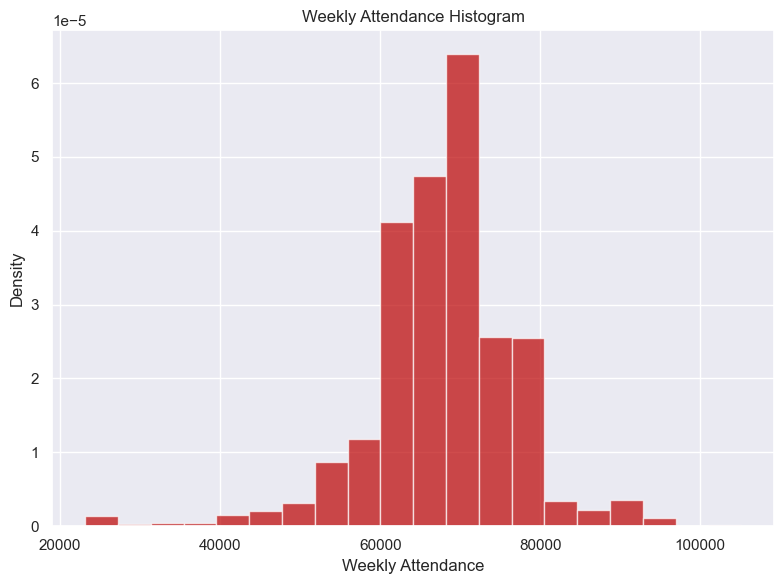

In [62]:
plt.figure(figsize=(8, 6))

# Plotting a histogram for the distribution of weekly attendance
plt.hist(df_result['weekly_attendance'], bins=20, density=True, alpha=0.7, color='#BB0000')

plt.xlabel('Weekly Attendance')
plt.ylabel('Density')
plt.title('Weekly Attendance Histogram')

plt.tight_layout()
plt.show()

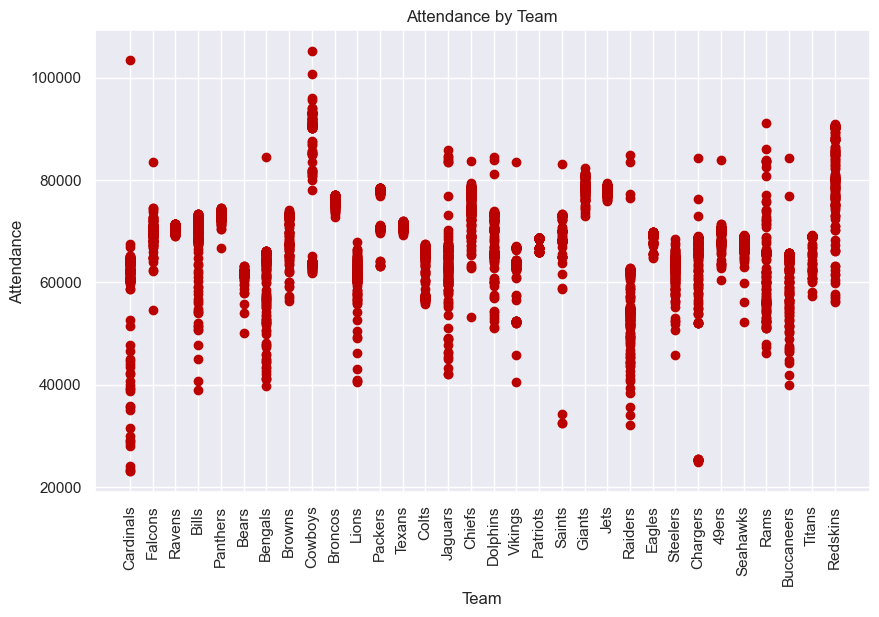

In [63]:
# Scatterplot for attendance on a team by team basis
plt.figure(figsize=(10,6))
plt.scatter(df_result['home_team_name'], df_result['weekly_attendance'], color='#BB0000')

plt.xlabel('Team')
plt.ylabel('Attendance')
plt.title('Attendance by Team')
plt.xticks(rotation=90)
plt.tight_layout

plt.show()

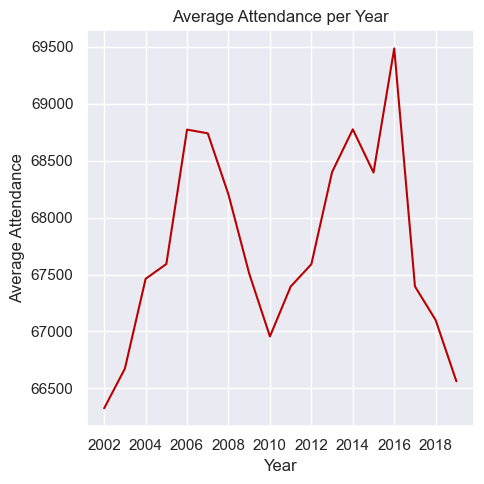

In [64]:
# League-wide average attendance from 2002 to 2019
avg_attendance_per_year = df_result.groupby('year')['weekly_attendance'].mean().reset_index()

plt.figure(figsize=(5, 5))
plt.plot(avg_attendance_per_year['year'], avg_attendance_per_year['weekly_attendance'], color='#BB0000')

plt.xlabel('Year')
plt.ylabel('Average Attendance')
plt.title('Average Attendance per Year')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

plt.show()

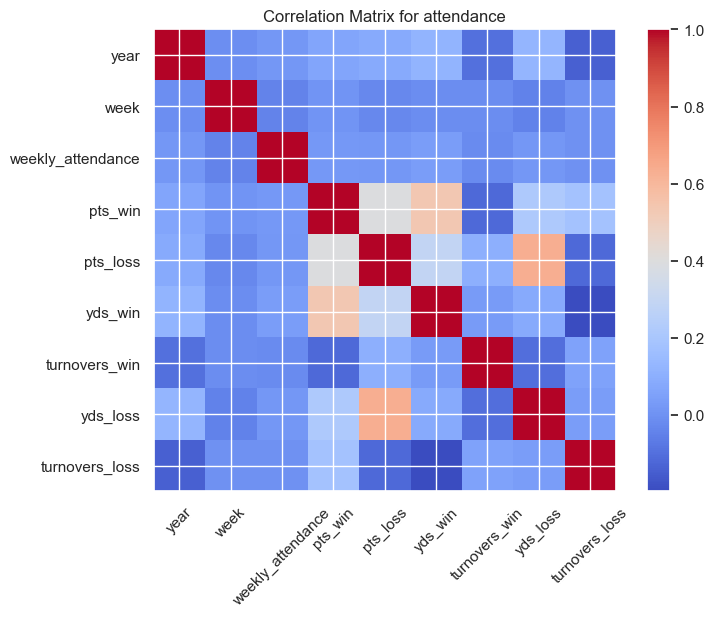

In [65]:
# This is showing ONLY the numerical values and how they correlate with one another
# The bluer, the less correlated. The redder, the more correlated...
# Note, the values down the diagonal are expected to be highly correlated, because it is comparing itself to itself
plt.figure(figsize=(8,6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Matrix for attendance")
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()


In [66]:
X = df_result.drop('weekly_attendance', axis=1)
y = df_result['weekly_attendance']
# 80/20 split for training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [67]:
scaler = StandardScaler()

In [68]:
scaled_dfs_train = []
scaled_dfs_test = []
for col in to_scale:
    scaled_train = scaler.fit_transform(X_train[[col]])
    scaled_test = scaler.transform(X_test[[col]])
    scaled_dfs_train.append(pd.DataFrame(scaled_train, columns=scaler.get_feature_names_out([col])))
    scaled_dfs_test.append(pd.DataFrame(scaled_test, columns=scaler.get_feature_names_out([col])))

X_train_scaled = pd.concat([X_train.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_train, axis=1)
X_test_scaled = pd.concat([X_test.drop(columns=to_scale).reset_index(drop=True)] + scaled_dfs_test, axis=1)

In [69]:
#converting our categorical data into 1s and 0s
# for the purposes of One-Hot Encoding, considering we cannot run
# categorical data through our models
encoded_dfs_train = []
encoded_dfs_test = []
for col in to_convert_categorical:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_train = encoder.fit_transform(X_train_scaled[[col]])
    encoded_test = encoder.transform(X_test_scaled[[col]])
    encoded_dfs_train.append(pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([col])))
    encoded_dfs_test.append(pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([col])))

X_train_encoded = pd.concat([X_train_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_train, axis=1)
X_test_encoded = pd.concat([X_test_scaled.drop(columns=to_convert_categorical).reset_index(drop=True)] + encoded_dfs_test, axis=1)

/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/tylerbang/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sp

In [70]:
# We create a SVR model here 
model = SVR()

In [71]:
# when compared to the linear model, SVR has
# significantly more hyperparameters that we need to tune
# grid search will take too long for this, given our data
param_grid = {
    'kernel': ['linear', 'poly', 'sigmoid', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.2, 0.5],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.5, 1.0],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'verbose': [True, False]
}

In [72]:
# still using mean squared error
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [73]:
#hyperparameter tuning through RandomizedSearchCV, 200 iterations so it does not take too long
search = RandomizedSearchCV(model, param_grid, scoring=scorer, cv=3, n_iter=200)
grid_result = search.fit(X_train_encoded, y_train)

[LibSVM]*
optimization finished, #iter = 266
epsilon = 13230.362308
obj = -50093348.544141, rho = -65862.725832
nSV = 246, nBSV = 244
[LibSVM]*
optimization finished, #iter = 273
epsilon = 13650.259435
obj = -53442820.395049, rho = -66127.181334
nSV = 246, nBSV = 244
[LibSVM]*
optimization finished, #iter = 262
epsilon = 13022.466416
obj = -49761337.663078, rho = -65886.555006
nSV = 246, nBSV = 244
[LibSVM]*
optimization finished, #iter = 37
epsilon = 31058.322779
obj = -8563735.599042, rho = -61123.376319
nSV = 26, nBSV = 24
[LibSVM]*
optimization finished, #iter = 55
epsilon = 33604.106716
obj = -8750380.894164, rho = -59263.887986
nSV = 27, nBSV = 23
[LibSVM]*
optimization finished, #iter = 35
epsilon = 33359.696563
obj = -8397815.180719, rho = -59283.425370
nSV = 26, nBSV = 24
[LibSVM]*
optimization finished, #iter = 33
epsilon = 31068.133183
obj = -858362.802034, rho = -61082.268627
nSV = 26, nBSV = 24
[LibSVM]*
optimization finished, #iter = 39
epsilon = 33830.899335
obj = -87782

In [74]:
# this stores the best parameters from the results
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'verbose': False, 'tol': 0.001, 'shrinking': True, 'nu': 0.9, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5, 'coef0': 1.0, 'C': 10.0}


In [75]:
# we predict our values here using the test data
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test_encoded)

# in a nutshell, mse and mae should ideally be close to zero
# if not, then we have a significant amount of error the larger it gets
#Our R2 score should ideally be close to 1, meaning that our model is fairly accurate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error: ", mae)
print("R2 Score: ", r2_score)

Mean Squared Error: 69534305.19609992
Mean Absolute Error:  5536.610732998782
R2 Score:  0.1469005661150553


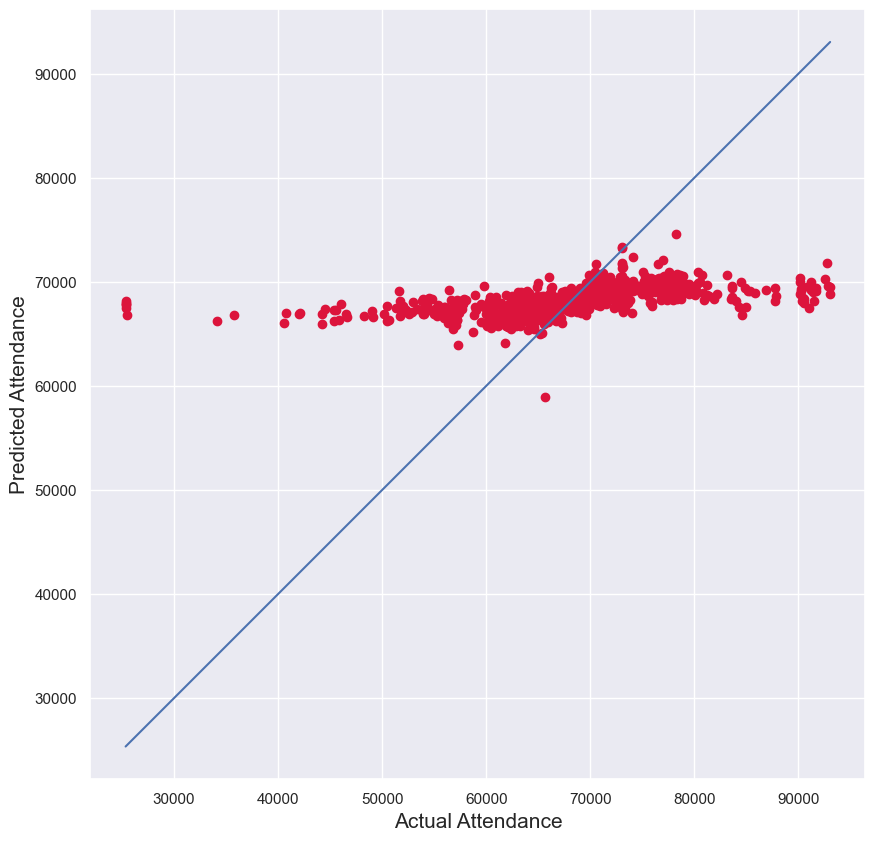

In [76]:
# Here, we print a scatter plot that shows us how our model performed
# the closer to the line, the more the model had accurately guessed the attendance
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Attendance', fontsize=15)
plt.ylabel('Predicted Attendance', fontsize=15)
plt.axis('equal')
plt.show()